In [ ]:
import os 
import timeit 

start_time = timeit.default_timer()

subj = []
obj = []

with open("data/subj/subj.subjective", 'r') as f:
    for line in f:
        if len(line.strip()):
            subj.append(line.strip())
            
with open("data/subj/obj.objective", 'r') as f:
    for line in f:
        if len(line.strip()):
            obj.append(line.strip())

In [2]:
import numpy as np 

def extract_info(text, name):
    print("Name: {0}".format(name))
    print("Sentences: {0}".format(len(text)))      
    print("Avg Words in Sentence: {0}".format(np.mean([len(line.split()) for line in text])))
    
    vocabulary = set([word.lower() for line in text for word in line.split()])
    print("Vocabulary size: {0}".format(len(vocabulary)))
    print("Lexical Diversity: {0}".format(len([word.lower() for line in text for word in line.split()])/len(vocabulary)))

In [3]:
extract_info(subj, "Subjectivity")

Name: Subjectivity
Sentences: 5000
Avg Words in Sentence: 22.8664
Vocabulary size: 14849
Lexical Diversity: 7.699643073607651


In [4]:
extract_info(obj, "Objectivity")

Name: Objectivity
Sentences: 5000
Avg Words in Sentence: 25.2478
Vocabulary size: 15474
Lexical Diversity: 8.158136228512344


# PROCESS TEXT

Create a processor using nltk and spacy with options to lower words, remove stop words, lemmatize and add dependency information.

In [5]:
from nltk.corpus import stopwords as stopword_loader
import string
import nltk
import sys
import spacy

nlp = spacy.load("en_core_web_sm")


stopwords = set(stopword_loader.words("english"))

def preprocess_text(text, use_dep=False, lemmatize=False, remove_stops=True, lower=True):
    
    processed_text = []
    for progress, line in enumerate(text):
        # split line into sentences 
        #sentences = tokenizer.tokenize(line)
        sentences = [line]
        
        for line in sentences:
            # remove punctuation from line and split into word tokens
            line = line.translate(str.maketrans('', '', string.punctuation)).replace('  ', ' ')
            processed_line = []
            
            if lower:
                line = line.lower()
                
            doc = nlp(line)
            
            for token in doc:
                # move to lower case and lemmatize
                
                if remove_stops:
                    if token.is_stop:
                        continue
                    
                if lemmatize:
                    proc_token = str(token.lemma_)
                    head_token = str(token.head.lemma_)
                else:
                    proc_token = str(token.text)
                    head_token = str(token.head.text)
                    
                if use_dep:
                    #proc_token = proc_token + '_' + token.pos_ #+ '_' + token.dep_
                    proc_token = "{0} {1} {2}".format(proc_token, token.dep_, head_token)
                    
                if not proc_token.isspace():
                    processed_line.append(proc_token)
            
            if len(processed_line) > 0:
                processed_text.append(processed_line)
            
        
        sys.stdout.write("\r" + str(progress+1) + '/' + str(len(text)) + ' Lines Processed: ' + str(len(processed_text)))     
        
    return processed_text

In [6]:
subj_processed = preprocess_text(subj, remove_stops=True, lower=True, lemmatize=True)

5000/5000 Lines Processed: 5000

In [7]:
obj_processed = preprocess_text(obj, remove_stops=True, lower=True, lemmatize=True)

5000/5000 Lines Processed: 5000

# WORD CLOUD PLOTS

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

subj_lines = ' '.join(word for line in subj_processed for word in line)
obj_lines = ' '.join(word for line in obj_processed for word in line)

subj_wordcloud = WordCloud(width = 800, height = 800, 
                #background_color ='white', 
                stopwords = stopwords, 
                collocations=True,
                min_font_size = 10).generate(subj_lines) 

obj_wordcloud = WordCloud(width = 800, height = 800, 
                #background_color ='white', 
                stopwords = stopwords, 
                collocations=True,
                min_font_size = 10).generate(obj_lines) 

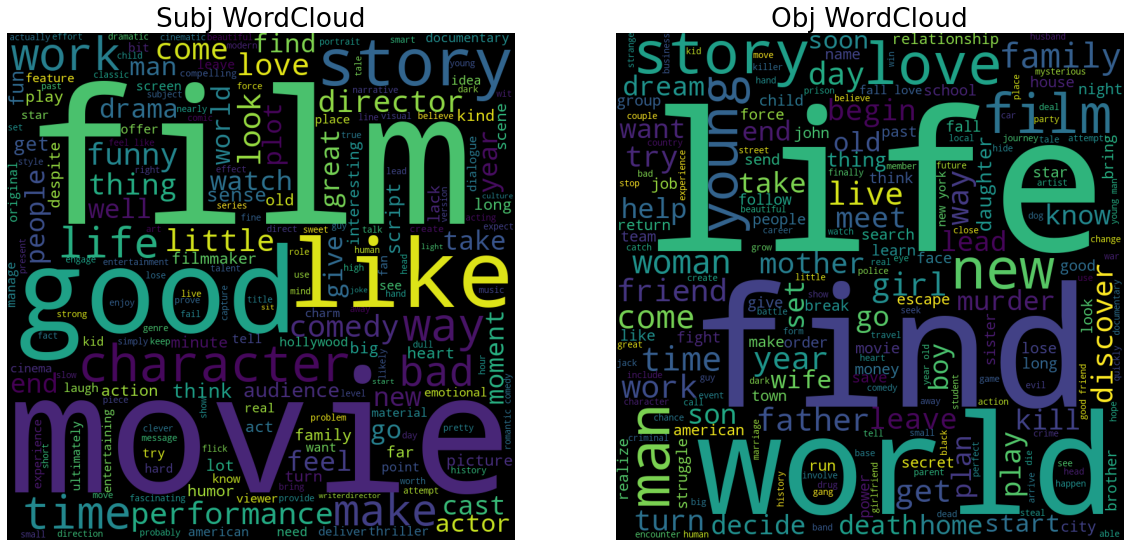

In [9]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), facecolor=None)

axes[0].imshow(subj_wordcloud)
axes[0].set_title("Subj WordCloud", )
axes[0].axis("off")

axes[1].imshow(obj_wordcloud)
axes[1].set_title("Obj WordCloud")
axes[1].axis("off")
  
plt.show() 

In [10]:
from collections import Counter 

def generate_words(lines):
    # get all non stop words
    for line in lines:
        for word in line:
            yield word
        
obj_wordcount = Counter(generate_words(obj_processed))
subj_wordcount = Counter(generate_words(subj_processed))

In [11]:
def plot_wordcounts(data, name, fontsize=20, rotation=0):
    n_groups = len(data)

    vals = [x[1] for x in data]
    legends = [x[0] for x in data]

    fig, ax = plt.subplots(figsize=(20,12))

    index = np.arange(n_groups)
    bar_width = 0.25

    opacity = 0.4

    rects1 = plt.bar(index, vals, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Ocurrences')


    plt.xlabel('Occurrences')
    plt.ylabel('Words')
    plt.title(name)
    plt.xticks(index + bar_width, legends, )
    plt.xticks(fontsize=fontsize, rotation=rotation)

    plt.tight_layout()
    plt.show()
    

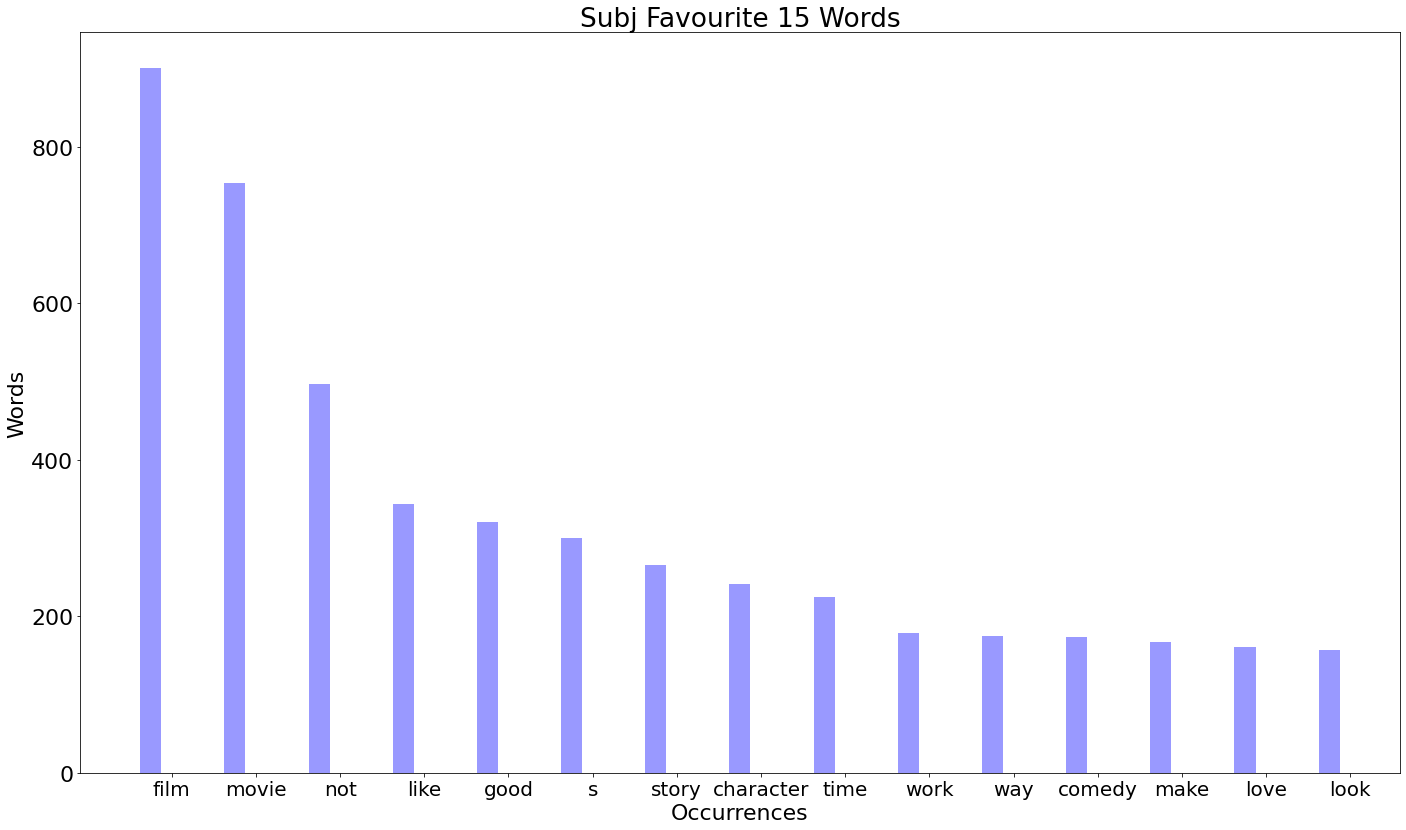

In [12]:
plot_wordcounts(subj_wordcount.most_common()[:15], 'Subj Favourite 15 Words')

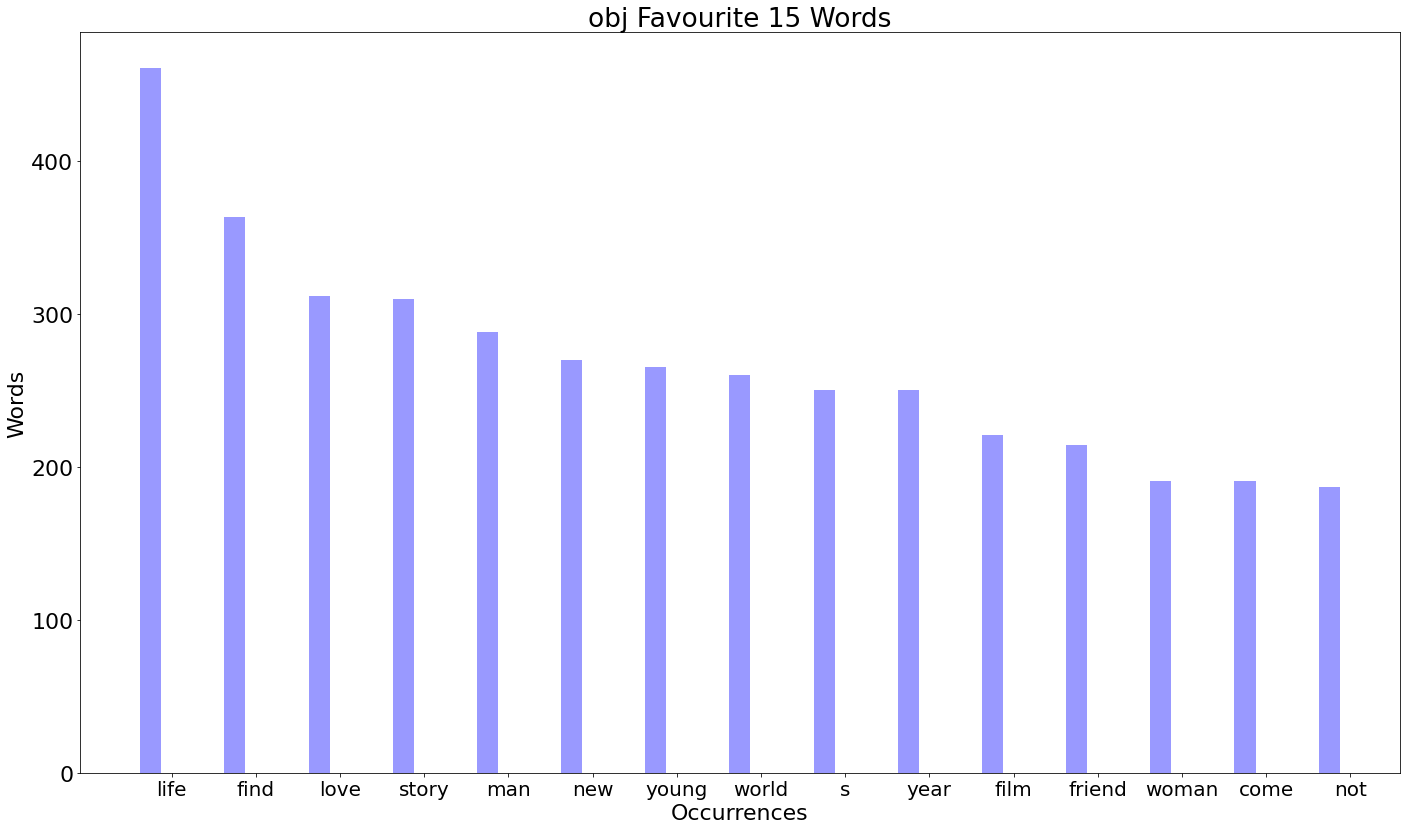

In [13]:
plot_wordcounts(obj_wordcount.most_common()[:15], 'obj Favourite 15 Words')

# TOPIC MODELLING

In [14]:
# Create dictionaries and filter down words
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

subj_dictionary = Dictionary(subj_processed)
obj_dictionary = Dictionary(obj_processed)

subj_dictionary.filter_extremes(no_below=15, keep_n=100000)
obj_dictionary.filter_extremes(no_below=15, keep_n=100000)

In [15]:
subj_bow_corpus = [subj_dictionary.doc2bow(doc) for doc in subj_processed]
obj_bow_corpus = [obj_dictionary.doc2bow(doc) for doc in obj_processed]

In [16]:
from gensim.models import LdaMulticore

subj_lda_model = LdaMulticore(subj_bow_corpus, num_topics=5, id2word=subj_dictionary, passes=2, workers=6)

In [17]:
obj_lda_model = LdaMulticore(obj_bow_corpus, num_topics=5, id2word=obj_dictionary, passes=2, workers=6)

In [18]:
print("Subj favourite topics")
print("")
for idx, topic in subj_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print("")

Subj favourite topics

Topic: 0 
Words: 0.056*"film" + 0.027*"movie" + 0.021*"s" + 0.020*"story" + 0.017*"good" + 0.015*"way" + 0.015*"year" + 0.012*"comedy" + 0.011*"thing" + 0.011*"character"

Topic: 1 
Words: 0.036*"film" + 0.034*"like" + 0.033*"good" + 0.015*"movie" + 0.014*"come" + 0.014*"not" + 0.013*"feel" + 0.012*"play" + 0.011*"performance" + 0.011*"director"

Topic: 2 
Words: 0.057*"movie" + 0.023*"film" + 0.016*"not" + 0.015*"story" + 0.014*"s" + 0.013*"character" + 0.012*"life" + 0.012*"feel" + 0.011*"watch" + 0.009*"fun"

Topic: 3 
Words: 0.024*"make" + 0.019*"film" + 0.019*"not" + 0.014*"love" + 0.011*"s" + 0.010*"drama" + 0.009*"funny" + 0.009*"like" + 0.009*"act" + 0.009*"tale"

Topic: 4 
Words: 0.038*"not" + 0.038*"movie" + 0.038*"film" + 0.023*"time" + 0.015*"like" + 0.012*"look" + 0.011*"work" + 0.011*"character" + 0.009*"script" + 0.009*"de"



In [19]:
print("Obj favourite topics")
print("")
for idx, topic in obj_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print("")

Obj favourite topics

Topic: 0 
Words: 0.037*"life" + 0.016*"man" + 0.014*"time" + 0.009*"day" + 0.009*"come" + 0.009*"friend" + 0.008*"live" + 0.008*"secret" + 0.008*"love" + 0.007*"get"

Topic: 1 
Words: 0.019*"love" + 0.019*"year" + 0.016*"man" + 0.014*"find" + 0.014*"world" + 0.014*"woman" + 0.010*"live" + 0.010*"come" + 0.010*"new" + 0.010*"young"

Topic: 2 
Words: 0.019*"new" + 0.016*"find" + 0.014*"girl" + 0.011*"want" + 0.011*"s" + 0.011*"world" + 0.010*"good" + 0.010*"know" + 0.009*"life" + 0.009*"school"

Topic: 3 
Words: 0.021*"life" + 0.013*"love" + 0.013*"story" + 0.012*"help" + 0.012*"s" + 0.012*"day" + 0.011*"friend" + 0.011*"young" + 0.010*"film" + 0.010*"mother"

Topic: 4 
Words: 0.022*"story" + 0.014*"find" + 0.012*"young" + 0.011*"not" + 0.011*"work" + 0.010*"kill" + 0.009*"way" + 0.009*"man" + 0.009*"love" + 0.009*"world"



# MOST USED TRIGRAM PHRASES (PHRASES OF LENGTH 3)

In [20]:
from nltk import ngrams

def process_ngrams(text, n=2):
    ngram_text = []
    
    for line in text:
        ngram_line = list(nltk.ngrams(line, n))
        if len(ngram_line) > 0:
            ngram_text.append(ngram_line)
            
    return ngram_text

subj_trigrams = process_ngrams(subj_processed, 3)
obj_trigrams = process_ngrams(obj_processed, 3)

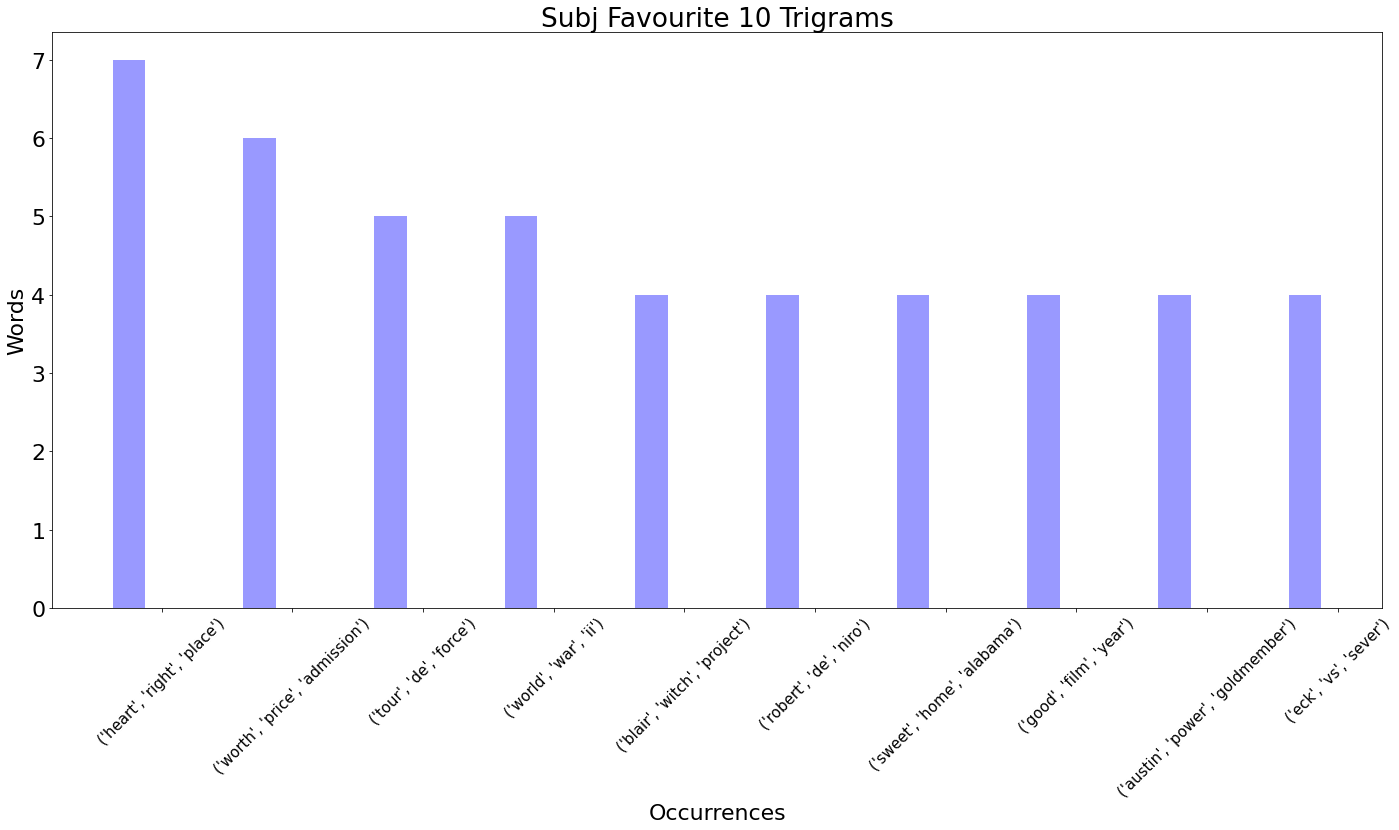

In [21]:
plot_wordcounts(Counter([w for line in subj_trigrams for w in line]).most_common()[:10], 'Subj Favourite 10 Trigrams', fontsize=15, rotation=45)

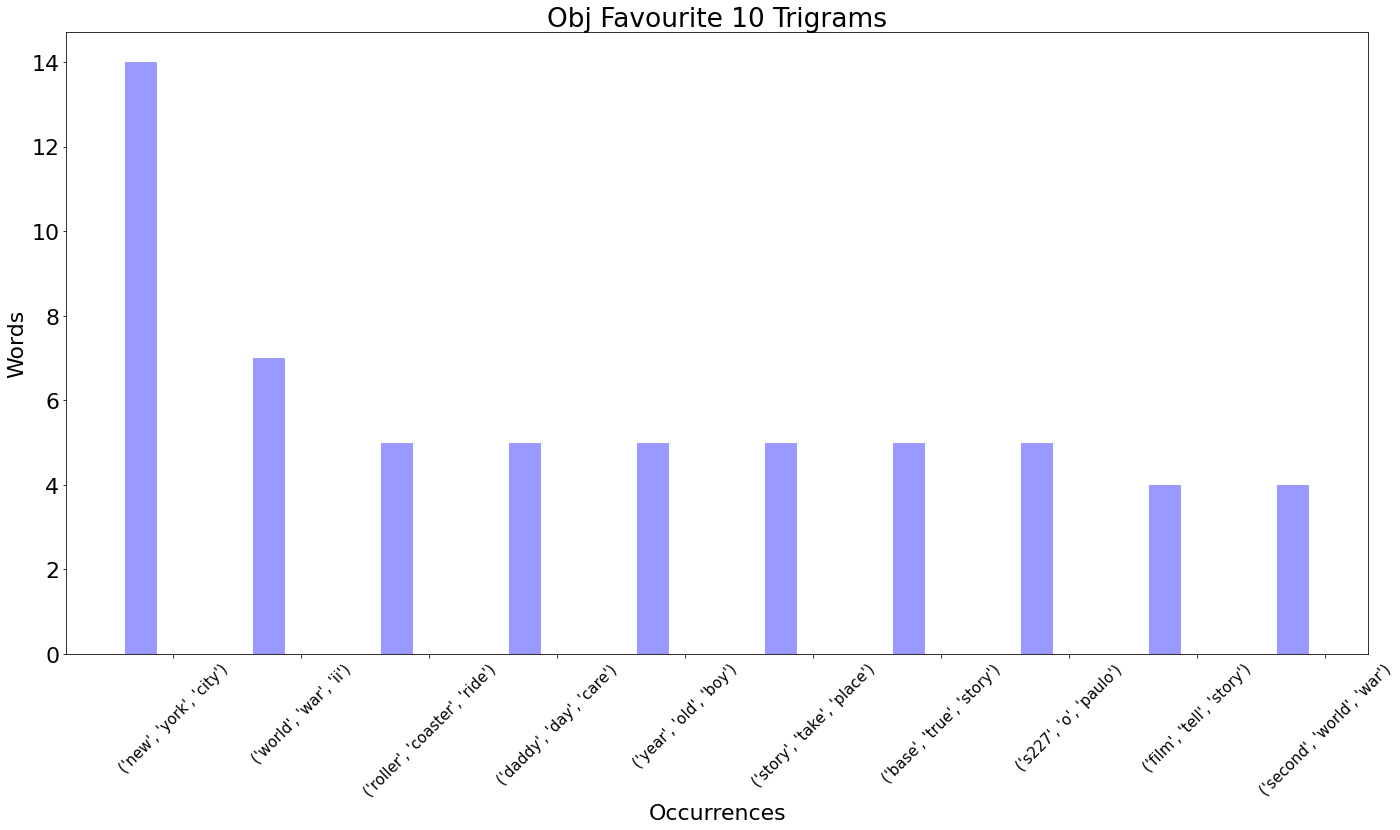

In [22]:
plot_wordcounts(Counter([w for line in obj_trigrams for w in line]).most_common()[:10], 'Obj Favourite 10 Trigrams', fontsize=15, rotation=45)

# PREDICTION

For the first part, we extract features using our preprocessed data (remove stops, lemmatise, lower). To build features, we use a Bag of words with tfidf to normalize. Furthermore, we use ngrams of sizes 1 to 3. Ngrams are small phrases of text that encode small bits of information that may be more useful for predictin when these words occur together rather than singular words (to see this, see the differences in the above plots). 

In [23]:
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

def get_data(text1, text2):
    X_text = []
    y = []
    
    for line in text1:
        X_text.append(line)
        y.append(0)
        
    for line in text2:
        X_text.append(line)
        y.append(1)
        
    return X_text, np.asarray(y)


def build_features(train_text, test_text, min_df=15, ngram_range=(1, 1), pca_dims=None):
    """
        Function to build text features from preprocessed data.
        
        Arguments:
            train_text: preprocessed text data used for training
            test_text: preprocessed text data used for testing
            ngram_range: Different ngrams to use (default: (1,1) [Unigrams only])
            pca_dims: Number of pca dimensions to reduce data, if None no pca is performed. (default: None)
    """
    tfidf = TfidfVectorizer(sublinear_tf=True, smooth_idf=True, min_df=min_df, norm='l2', ngram_range=ngram_range, lowercase=False)

    tfidf.fit(X_train_text)
    X_train = tfidf.transform(X_train_text).toarray()
    X_test = tfidf.transform(X_test_text).toarray()
    
    print("Feature Dims: {0}".format(X_train.shape[1]))

    if pca_dims is not None:
        pca = PCA(n_components=pca_dims)
        pca.fit(X_train)

        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
        
        print("Sum of explained variance: {0}".format(sum(pca.explained_variance_ratio_)))
        
    return X_train, X_test, tfidf.get_feature_names()

In [24]:
X_text, y = get_data(subj_processed, obj_processed)

X_text = [' '.join(line) for line in X_text]

In [25]:
TRAIN_INDEX = 9000
permutation = np.random.permutation(len(X_text))

X_train_text = [X_text[i] for i in permutation[:TRAIN_INDEX]]
X_test_text = [X_text[i] for i in permutation[TRAIN_INDEX:]]
y_train, y_test = y[permutation[:TRAIN_INDEX]], y[permutation[TRAIN_INDEX:]]

In [26]:
X_train, X_test, feature_names = build_features(X_train_text, X_train_text, ngram_range=(1,3))

Feature Dims: 1252


# For prediction, we test using a number of different models
- A standard logistics regression
- A naive bayes with likelyhood of features assumed to be gaussian (priors for labels set as 50%)
- An ensemble of trees using a random forest with max depth set at 200 with log2 features, and 50 estimators (trees)

These models give us a nice variety to explore the data

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

log_reg = LogisticRegression()
nb_clf = GaussianNB(priors=[0.5,0.5])
forest = RandomForestClassifier(n_estimators=50, n_jobs = -1, max_depth=200, max_features="log2")

In [28]:
print("Logistic Regression Scores")
log_reg.fit(X_train, y_train)
train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")

#================================================================================

print("Naive Bayes Scores")
nb_clf.fit(X_train, y_train)
train_preds = nb_clf.predict(X_train)
test_preds = nb_clf.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")


#================================================================================

forest.fit(X_train, y_train)
train_preds = forest .predict(X_train)
test_preds = forest .predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Logistic Regression Scores
Train Score: 89.52222222222223
Test Score: 86.6

Naive Bayes Scores
Train Score: 86.4
Test Score: 82.19999999999999

Train Score: 99.11111111111111
Test Score: 85.1


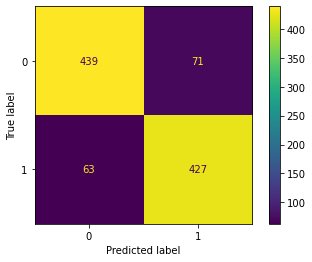

In [29]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log_reg, X_test, y_test) 
plt.show()

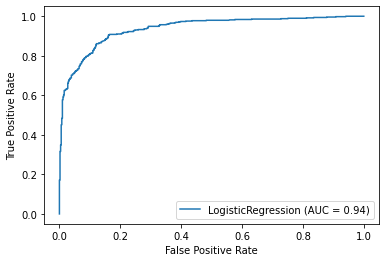

In [30]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(log_reg, X_test, y_test) 

# Decision trees can be a nice way to explore the features, we use a grid search with a few parameters and cross validation on the training set to find the best features 

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_features':('log2', 'sqrt'), 
              'max_leaf_nodes':[20, 30],
              'max_depth': [20, 30],
              'splitter': ('best', 'random'),
              'criterion': ('gini', 'entropy')}

tree = DecisionTreeClassifier()

grid_clf = GridSearchCV(tree, parameters, cv=5, verbose=1)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   19.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [20, 30],
                         'max_features': ('log2', 'sqrt'),
                         'max_leaf_nodes': [20, 30],
                         'splitter': ('best', 'random')},
             verbose=1)

In [32]:
print(grid_clf.best_params_)

{'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'splitter': 'best'}


In [33]:
tree = DecisionTreeClassifier(**grid_clf.best_params_)

tree.fit(X_train, y_train)
train_preds = tree.predict(X_train)
test_preds = tree.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Train Score: 66.08888888888889
Test Score: 65.2


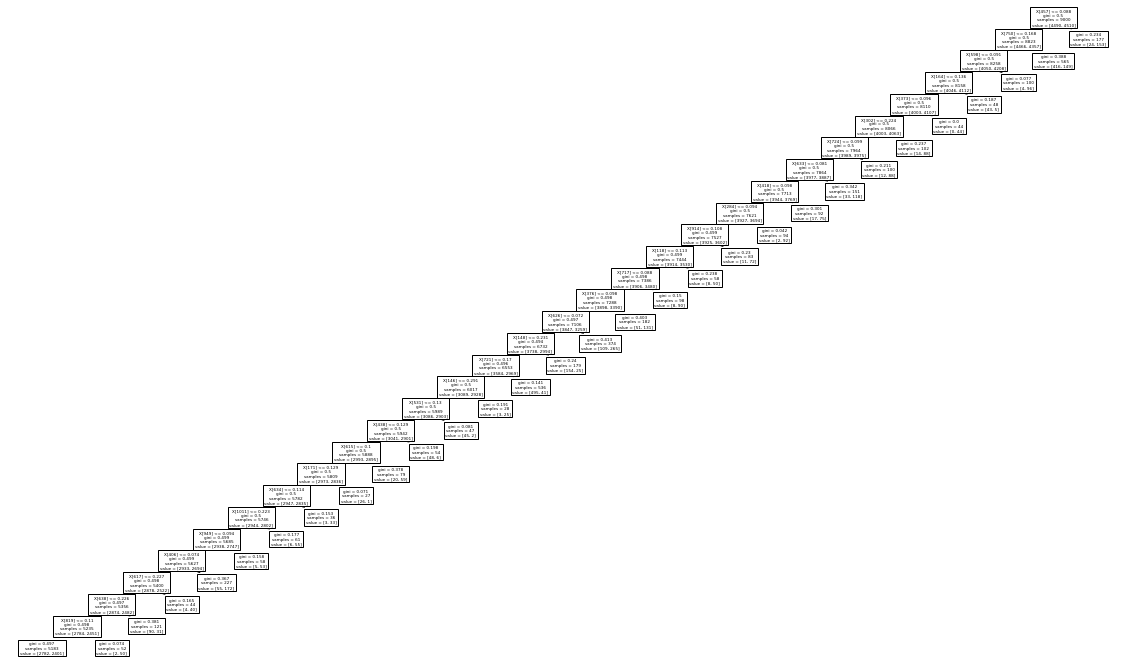

In [34]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,12))
plot_tree(tree)
plt.show()

# Try with dependency information
Word occurrence is a good feature predictor, but doesnt tell us about the how the words interact on a syntactical level. This time, we parse dependency information so that a token consists of the word (with preprocessing), the dependency label and the head that links the word to get our tokens. We dont remove the stop words as they're more functionally important to these features.

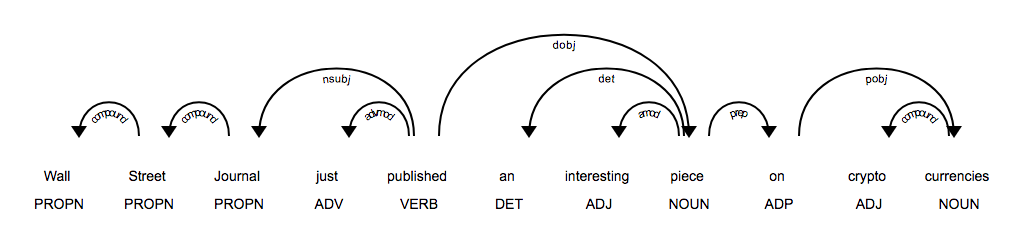

In [35]:
from IPython.display import Image
Image(filename='pics/dep.png')

In [36]:
subj_processed_dep = preprocess_text(subj, remove_stops=False, lower=True, lemmatize=True, use_dep=True)

5000/5000 Lines Processed: 5000

In [37]:
obj_processed_dep = preprocess_text(obj, remove_stops=False, lower=True, lemmatize=True, use_dep=True)

5000/5000 Lines Processed: 5000

In [38]:
X_text, y = get_data(subj_processed_dep, obj_processed_dep)

X_text = [' '.join(line) for line in X_text]

In [39]:
TRAIN_INDEX = 9000

X_train_text = [X_text[i] for i in permutation[:TRAIN_INDEX]]
X_test_text = [X_text[i] for i in permutation[TRAIN_INDEX:]]
y_train, y_test = y[permutation[:TRAIN_INDEX]], y[permutation[TRAIN_INDEX:]]

# We still use tfidf and unigrams with trigrams as they contain the information about the relationship between the words in the sentence

In [40]:
X_train, X_test, feature_names = build_features(X_train_text, X_train_text, ngram_range=(1,3))

Feature Dims: 8211


In [41]:
print("Example:", ' | '.join(subj_processed_dep[np.random.randint(500)]))

Example: too advmod timid | timid ROOT timid | to aux bring | bring xcomp timid | a det sense | sense dobj bring | of prep sense | closure pobj of | to prep bring | an det chapter | ugly amod chapter | chapter pobj to | of prep chapter | the det century | twentieth amod century | century pobj of


In [42]:
print("Logistic Regression Scores")
log_reg.fit(X_train, y_train)
train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")

#================================================================================

print("Naive Bayes Scores")
nb_clf.fit(X_train, y_train)
train_preds = nb_clf.predict(X_train)
test_preds = nb_clf.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")


#================================================================================

forest.fit(X_train, y_train)
train_preds = forest .predict(X_train)
test_preds = forest .predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Logistic Regression Scores
Train Score: 92.18888888888888
Test Score: 88.4

Naive Bayes Scores
Train Score: 90.61111111111111
Test Score: 86.2

Train Score: 100.0
Test Score: 82.89999999999999


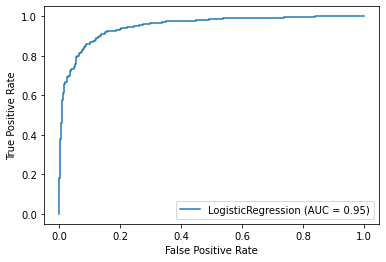

In [43]:
plot_roc_curve(log_reg, X_test, y_test) 

# Gradient Boosting (light)
Try a light weight gradient boosting model to see if this type of model performs any better

In [44]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(num_leaves=100, learning_rate=0.04, n_estimators=100)

In [45]:
model_lgb.fit(X_train, y_train)
train_preds = model_lgb.predict(X_train)
test_preds = model_lgb.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Train Score: 96.81111111111112
Test Score: 85.8


# Now try a serious ensemble of stacked models 

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.model_selection import KFold

class StackingAveragedModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        '''
        base_models: A list of base models that will be stacked. 
        meta_model: A single model that will be used to stack the base models. 
        n_folds: The number of folds to be used in cross-validation. 
        '''
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        
        # Define a holder for the base_models. 
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        # Define a KFold object used to determine the CV fold indexes. 
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Define a container for the predictions of each of the base models. 
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict_proba(X[holdout_index])[:,0]
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Train the meta-model on the out-of-fold predictions of the base models for the training dataset.
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Now use the trained meta model to predict the output using the predictions of the base models for 
    # the test dataset.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict_proba(X)[:,0] for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [47]:
lasso = LogisticRegression('l1', C=0.9995, solver='saga')
tree = DecisionTreeClassifier()
elnet = LogisticRegression('elasticnet', C=0.9995, l1_ratio=0.9, solver='saga')
nb_clf = GaussianNB(priors=[0.5,0.5])

stacked_averaged_models = StackingAveragedModels(base_models = (elnet, nb_clf, tree),
                                                 meta_model = lasso, n_folds=5)

# Warning: Takes a long time to run 

In [48]:
stacked_averaged_models.fit(X_train, y_train)

StackingAveragedModels(base_models=(LogisticRegression(C=0.9995, l1_ratio=0.9,
                                                       penalty='elasticnet',
                                                       solver='saga'),
                                    GaussianNB(priors=[0.5, 0.5]),
                                    DecisionTreeClassifier()),
                       meta_model=LogisticRegression(C=0.9995, penalty='l1',
                                                     solver='saga'))

In [49]:
train_preds = stacked_averaged_models.predict(X_train)
test_preds = stacked_averaged_models.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")


Train Score: 91.5111111111111
Test Score: 88.8



# Average Bag of words using Word2Vec

Average word2vec tokens for each word in sentence. Use larger vector size with standard window. Min count is 1 (low count words perform poorly at encoding semantics) but going higher may mean we have sentence with zero vectors (a serious problem here). We use high negative samples to counter act, and use skip-gram (predict context using target) without softmax (so dot product plus sigmoid) which should be more suited to a varied and small dataset of words. This approach is known as Noise Contrast Estimation and should work a lot better for our data (SEE DIAGRAM A).

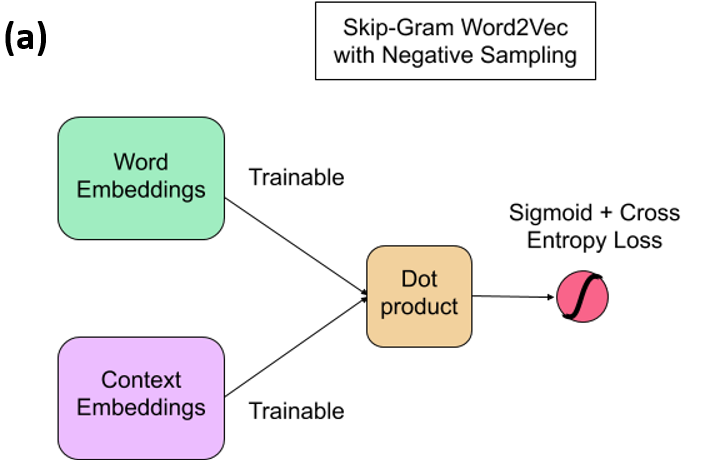

In [50]:
from IPython.display import Image
Image(filename='pics/arch_trunc.png')

In [51]:
X_text, y = get_data(subj_processed, obj_processed)

X_text = [' '.join(line) for line in X_text]

TRAIN_INDEX = 9000

X_train_text = [X_text[i] for i in permutation[:TRAIN_INDEX]]
X_test_text = [X_text[i] for i in permutation[TRAIN_INDEX:]]
y_train, y_test = y[permutation[:TRAIN_INDEX]], y[permutation[TRAIN_INDEX:]]

In [64]:
from gensim.models import Word2Vec

vector_size = 100

model = Word2Vec([line.split() for line in X_train_text], size=vector_size, window=5, min_count=1, workers=4, hs=0, negative=20, sg=1)

In [65]:
model.wv.most_similar("film")

[('make', 0.9918766021728516),
 ('funny', 0.9914138913154602),
 ('character', 0.9890449047088623),
 ('great', 0.9854011535644531),
 ('fun', 0.9853485822677612),
 ('kind', 0.9848805665969849),
 ('idea', 0.983879804611206),
 ('laugh', 0.9835848808288574),
 ('lot', 0.9835267663002014),
 ('movie', 0.980635404586792)]

In [66]:
X_train = np.zeros((TRAIN_INDEX, vector_size))
X_test = np.zeros((len(X_text) - TRAIN_INDEX, vector_size))

for num in range(TRAIN_INDEX):
    X_train[num,:] = np.mean(np.asarray([model.wv[w] for w in X_train_text[num].split() if w in model.wv.vocab]), axis=0)
    
for num in range(len(X_text) - TRAIN_INDEX):
     X_test[num,:] = np.mean(np.asarray([model.wv[w] for w in X_test_text[num].split() if w in model.wv.vocab]), axis=0)

In [67]:
print("Logistic Regression Scores")
log_reg.fit(X_train, y_train)
train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")

#================================================================================

print("Naive Bayes Scores")
nb_clf.fit(X_train, y_train)
train_preds = nb_clf.predict(X_train)
test_preds = nb_clf.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")


#================================================================================

forest.fit(X_train, y_train)
train_preds = forest .predict(X_train)
test_preds = forest .predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Logistic Regression Scores
Train Score: 81.03333333333333
Test Score: 81.2

Naive Bayes Scores
Train Score: 79.12222222222223
Test Score: 80.30000000000001

Train Score: 99.97777777777777
Test Score: 81.5


# TSNE plot uses manifold learning to preserve the distance between points while reducing the dimensionality of the data. We test out word embeddings for the first 3000 words, and use pca to first reduce the dimensions to 50.

In [68]:
embeddings = model.wv.syn0[:3000,:]

D:\Miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [69]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200)
pca = PCA(n_components=50)

In [70]:
tsne_matrix = tsne.fit_transform(pca.fit_transform(embeddings))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.024s...
[t-SNE] Computed neighbors for 3000 samples in 0.304s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.012798
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.896446
[t-SNE] KL divergence after 1000 iterations: 1.390520


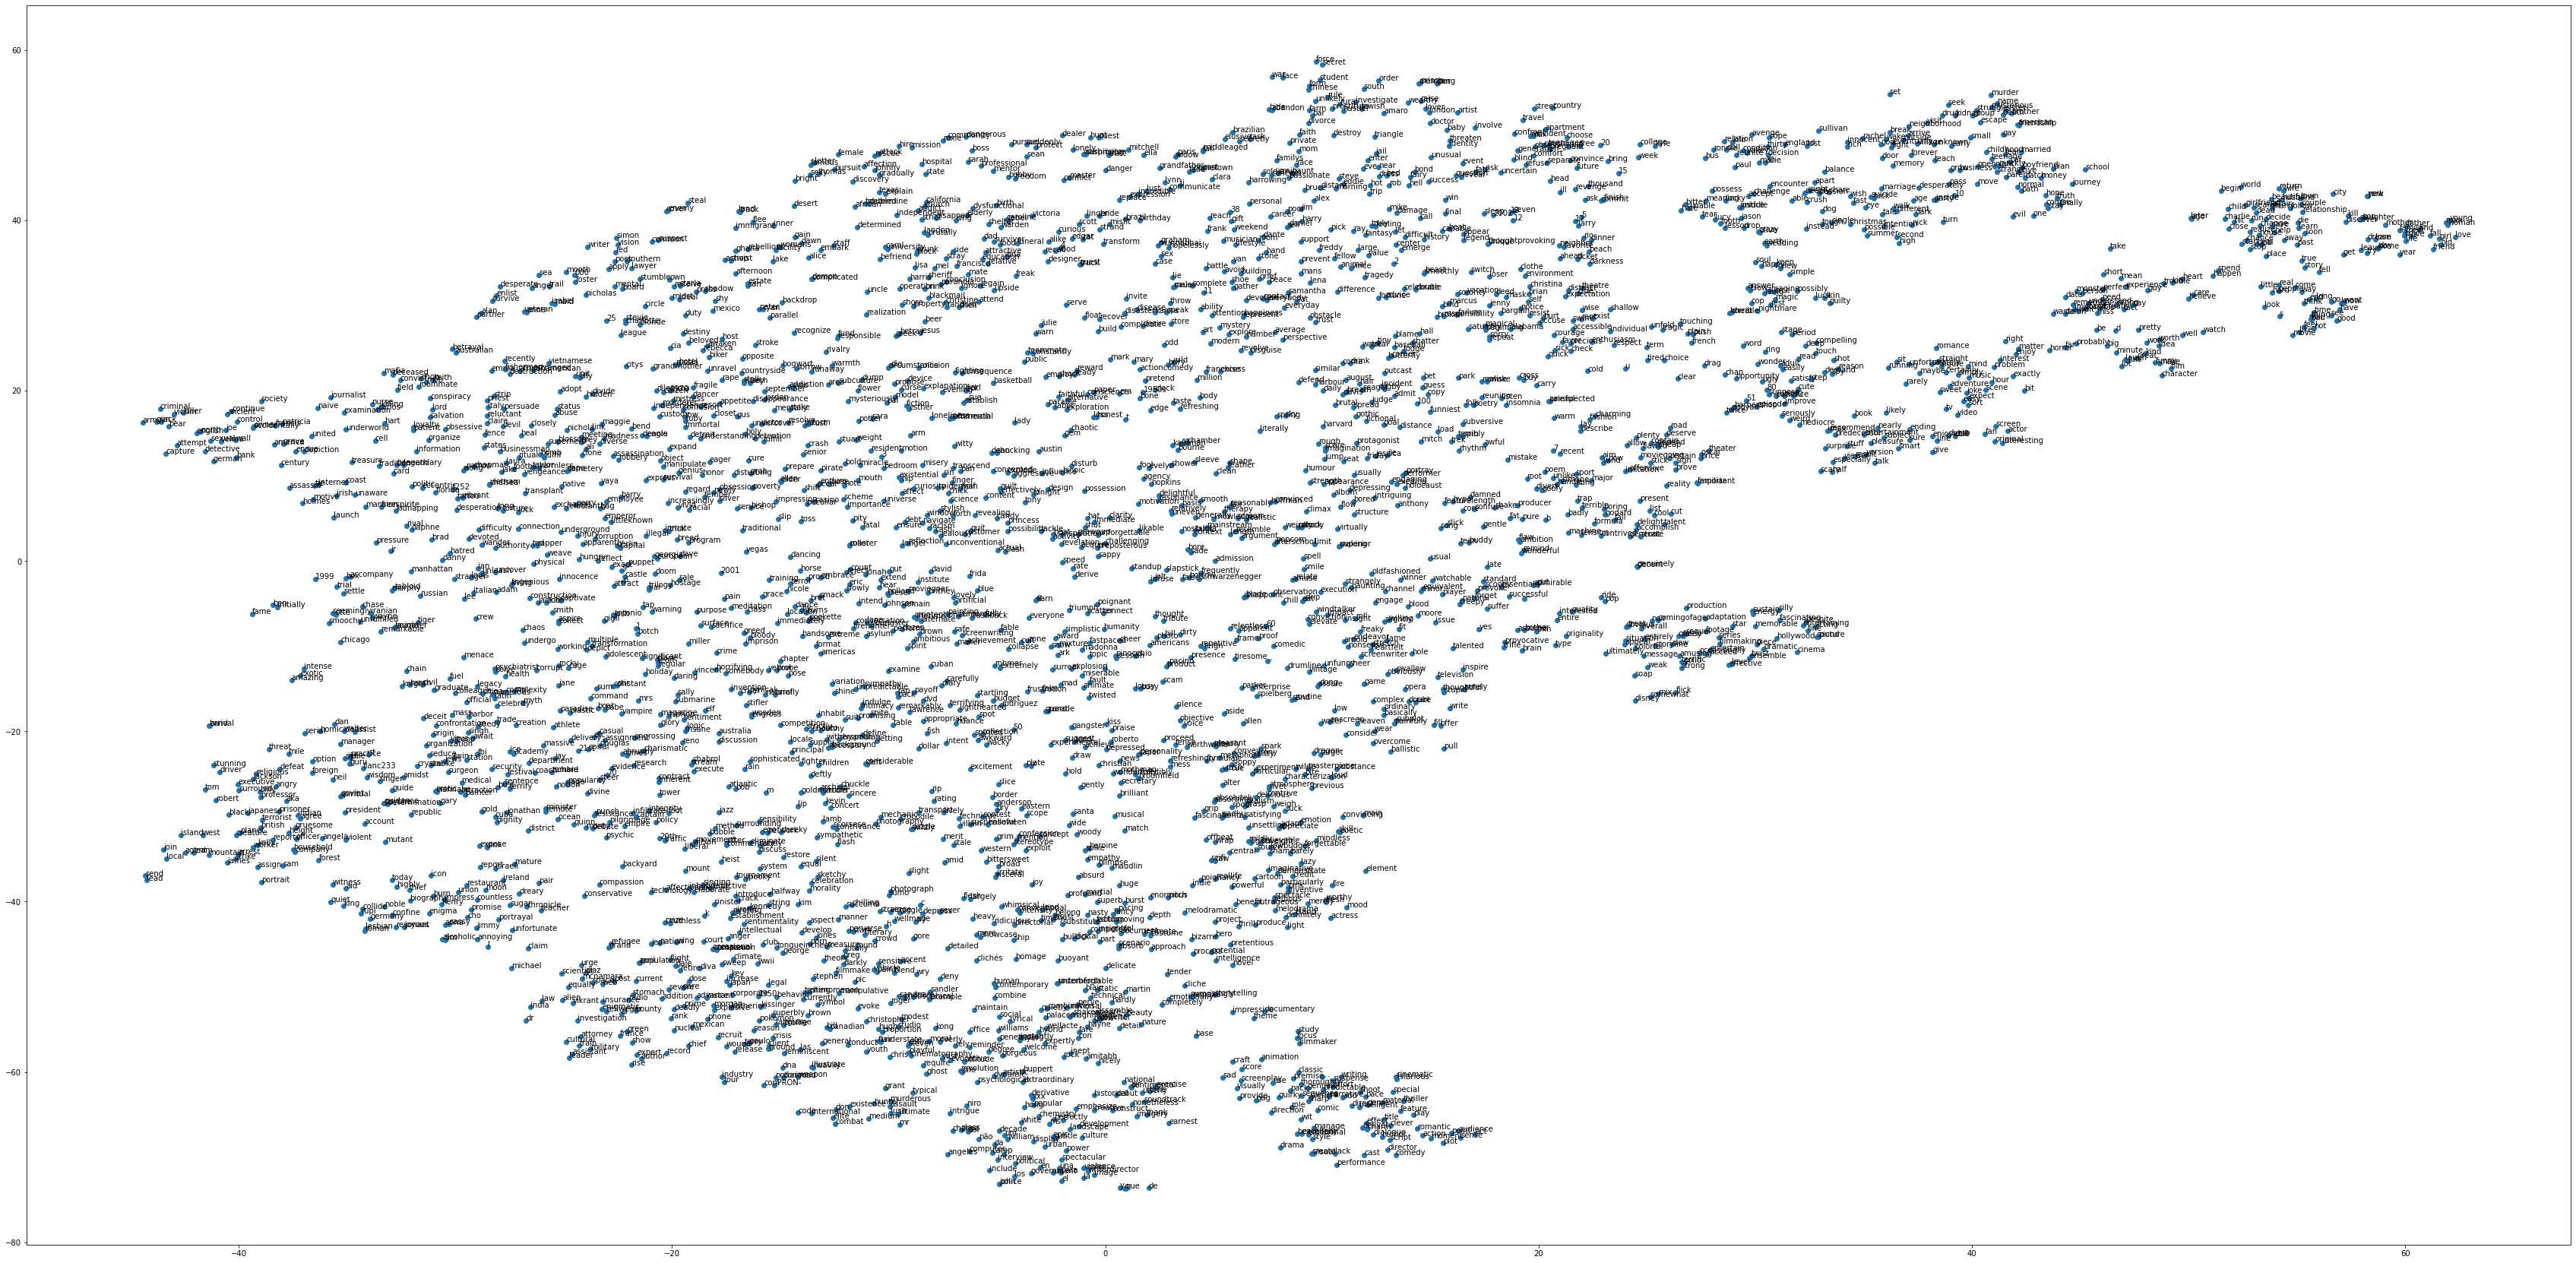

In [71]:
fig, ax = plt.subplots(figsize=(60,30))
ax.scatter(tsne_matrix[:,0], tsne_matrix[:,1])

for i, txt in enumerate(model.wv.index2word[:3000]):
    ax.annotate(txt, (tsne_matrix[i,0], tsne_matrix[i,1]))

# Quick Avegage BOW with FastText model

Works similarly to word2vec but predicts the context of ngram characters in words, which should help with low occurrence and out of vocabulary words with this dataset. Morphological information should also help improve model. We keep paramters similar to word2vec but add a higher min count. (Cant use higher workers because there is a bug with gensim fasttext). In general the word embeddings probably need more data to outperform feature extraction. Apply pretrained word embeddings would give better results 

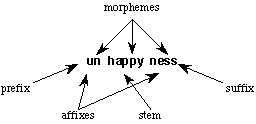

In [72]:
from IPython.display import Image
Image(filename='pics/morph.gif', width=500, height=600)

In [73]:
from gensim.models.fasttext import FastText 

vector_size=100

model = FastText([line.split() for line in X_train_text], size=vector_size, window=5, min_count=5, hs=0, negative=20, sg=1)

In [74]:
model.wv.most_similar("film") # Much better word similarity understanding!

[('act', 0.9994214177131653),
 ('acting', 0.999256432056427),
 ('king', 0.9984018802642822),
 ('moving', 0.997936487197876),
 ('interesting', 0.9975085258483887),
 ('ring', 0.9974883794784546),
 ('make', 0.9970812797546387),
 ('actor', 0.9970305562019348),
 ('writing', 0.9966813325881958),
 ('plot', 0.996374249458313)]

In [75]:
# We can also infer meaning of words outside vocab, or dont exist
# Consider the mythical Wampinuk https://www.aclweb.org/anthology/P14-1132.pdf

model.wv.most_similar("wampimuk") 

[('mitch', 0.9996597766876221),
 ('tie', 0.9996440410614014),
 ('wannabe', 0.9996417164802551),
 ('halfway', 0.9996349811553955),
 ('stay', 0.9996275901794434),
 ('botch', 0.9996248483657837),
 ('hour', 0.999624490737915),
 ('damn', 0.9996178150177002),
 ('snow', 0.9996128678321838),
 ('knee', 0.9996103644371033)]

In [76]:
X_train = np.zeros((TRAIN_INDEX, vector_size))
X_test = np.zeros((len(X_text) - TRAIN_INDEX, vector_size))

for num in range(TRAIN_INDEX):
    X_train[num,:] = np.mean(np.asarray([model.wv[w] for w in X_train_text[num].split()]), axis=0)
    
for num in range(len(X_text) - TRAIN_INDEX):
     X_test[num,:] = np.mean(np.asarray([model.wv[w] for w in X_test_text[num].split()]), axis=0)

In [77]:
print("Logistic Regression Scores")
log_reg.fit(X_train, y_train)
train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")

#================================================================================

print("Naive Bayes Scores")
nb_clf.fit(X_train, y_train)
train_preds = nb_clf.predict(X_train)
test_preds = nb_clf.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")


#================================================================================

forest.fit(X_train, y_train)
train_preds = forest .predict(X_train)
test_preds = forest .predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Logistic Regression Scores
Train Score: 80.60000000000001
Test Score: 83.2

Naive Bayes Scores
Train Score: 80.32222222222222
Test Score: 81.8

Train Score: 99.96666666666667
Test Score: 82.6


# Demonstrate with Spacy GloVe vectors
To show how transfer learning can be performed, we use the pretrained spacy token vectors trained on a large text dataset and use average BOW vectors to predict (vector dimensions must be 96). Using a bigger language model from spacy should provide better performance

In [78]:
vector_size = 96

X_train = np.zeros((TRAIN_INDEX, vector_size))
X_test = np.zeros((len(X_text) - TRAIN_INDEX, vector_size))

for num in range(TRAIN_INDEX):
    vector = np.zeros(vector_size)
    line = X_train_text[num]
    
    for token in nlp(line):
        vector += token.vector
    X_train[num,:] = vector / len(line.split())
    
for num in range(len(X_text) - TRAIN_INDEX):
    vector = np.zeros(vector_size)
    line = X_test_text[num]
    
    for token in nlp(line):
        vector += token.vector
    X_test[num,:] = vector / len(line.split())

In [79]:
print("Logistic Regression Scores")
log_reg.fit(X_train, y_train)
train_preds = log_reg.predict(X_train)
test_preds = log_reg.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")

#================================================================================

print("Naive Bayes Scores")
nb_clf.fit(X_train, y_train)
train_preds = nb_clf.predict(X_train)
test_preds = nb_clf.predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))
print("")


#================================================================================

forest.fit(X_train, y_train)
train_preds = forest .predict(X_train)
test_preds = forest .predict(X_test)

print("Train Score: {0}".format(accuracy_score(train_preds, y_train) * 100))
print("Test Score: {0}".format(accuracy_score(test_preds, y_test) * 100))

Logistic Regression Scores
Train Score: 72.06666666666666
Test Score: 73.4

Naive Bayes Scores
Train Score: 65.24444444444445
Test Score: 67.60000000000001



D:\Miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Score: 99.9888888888889
Test Score: 70.89999999999999


# DEEP LEARNING
Next, we use a shallow deep learning model to predict the label. The network uses a set of vector embeddings which learns during training. The ngram features worked quite well, so we use a 1D CNN to move over the text in strides of 3 (equivalent of ngrams of size 3). 

The text is converted into a set of embedding vectors and padded before passing to the CNN's which have filters that learn combinations of ngrams which give the best performance. If we simplify matters, we can simply say that Global max pooling means that each filter can only choose one ngram and a score for that ngram. We then weight the scores for each using a linear layer which uses the dot prodict followed by a sigmoid activation which normalizes the output to a probability distribution. 

I trained on a GPU because its faster but this isnt required.

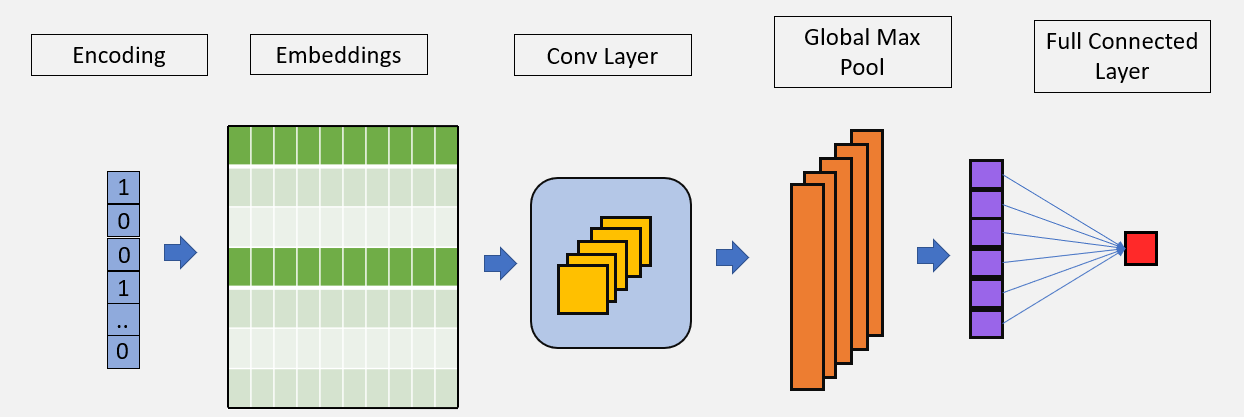

In [80]:
from IPython.display import Image
Image(filename='pics/cnn.png')

In [81]:
import torchtext

TEXT = torchtext.data.Field(fix_length=200, lower=True)
LABEL = torchtext.data.Field(sequential=False, unk_token=None)
fields = (("text", TEXT), ("label", LABEL))

X_text, y = get_data(subj, obj)

examples = []

for text, label in zip(X_text, y):
    examples.append(torchtext.data.Example.fromlist([text.split(), label], fields))

data = torchtext.data.Dataset(examples, fields)

In [82]:
train, test = data.split(split_ratio=0.9, stratified=True)

In [83]:
TEXT.build_vocab(train.text)
LABEL.build_vocab(train.label)

In [84]:
train_iter = torchtext.data.Iterator(train, batch_size=64, shuffle=True)
test_iter = torchtext.data.Iterator(test, batch_size=64, shuffle=False)

In [85]:
import torch 
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self, vocabulary, emb_dims, filters, kernel_size, maxlen, num_classes):
        super(Model, self).__init__()
        
        self.embeddings = torch.nn.Embedding(vocabulary, emb_dims)
        self.conv1d = torch.nn.Conv1d(emb_dims, filters, kernel_size, stride=3)
        self.dense = torch.nn.Linear(filters, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
        
    def get_features(self, x):
        forward1 = torch.transpose(self.embeddings(x), 1,2)
        
        return F.relu(self.conv1d(forward1))
        
    def forward(self, x):
        
        forward2 = self.dropout(self.get_features(x))
        
        
        forward3 = F.max_pool1d(forward2, forward2.shape[2]).squeeze(2)
        forward3 = self.dense(forward3).squeeze(1)
        
        return forward3

In [86]:
!nvidia-smi

Wed Aug 12 13:36:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.23       Driver Version: 442.23       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8     4W /  N/A |    652MiB /  6144MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [104]:
model = Model(len(TEXT.vocab.itos), 300, 32, 3, 200, 1).cuda()

In [105]:
loss = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
op = torch.optim.Adam(model.parameters(), lr=1e-4)

In [106]:
model.train()

Model(
  (embeddings): Embedding(22560, 300)
  (conv1d): Conv1d(300, 32, kernel_size=(3,), stride=(3,))
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [107]:
import sys 
from sklearn.metrics import accuracy_score
import timeit 

def binary_accuracy(y, preds):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train_network(model, op, loss, epochs, data_loader, training=False):
    start_time = timeit.default_timer()
    
    if training:
        model.train()
    else:
        model.eval()
    
    for epoch in range(epochs):
        losses = 0
        accs = 0

        for step, batch in enumerate(data_loader):
            x, y = batch.text.T, batch.label
            pred = model(x.long().cuda())
            y = y.float().cuda()
            batch_loss = loss(pred, y)
            batch_acc = binary_accuracy(y.cpu().detach(), pred.cpu().detach())

            losses += batch_loss.cpu().detach()
            accs += batch_acc
            
            if training:
                op.zero_grad()
                batch_loss.backward()
                op.step()
            sys.stdout.write('\r' + 'Epoch: ' + str(epoch) + '   Progress: ' + str(step) + 
                               '/' + str(len(data_loader)) + '   Loss: ' + str(np.around(losses/ (step+1), 3)) + '   Acc: ' + str(np.around(accs/ (step+1), 3)))

    print('')
    print(timeit.default_timer() - start_time)

In [108]:
epochs = 20

print("TRAINING:")
train_network(model, op, loss, epochs, train_iter, training=True)

print("")
print("TESTING:")
train_network(model, op, loss, 1, test_iter, training=False)

TRAINING:
Epoch: 19   Progress: 140/141   Loss: tensor(0.2200)   Acc: tensor(0.9180)
31.139680800000065

TESTING:
Epoch: 0   Progress: 15/16   Loss: tensor(0.3700)   Acc: tensor(0.8330)
0.0729282999999441


# Interpreting The Network
We can interpret the results by exploring the ngrams produced by the network and how they weight sentences. This is known as local interpretation. Each embedding is dot producted with the embeddings of in strides of 3, and the sum gives the score. We can use this score to see what each filter is looking for. https://arxiv.org/pdf/1809.08037.pdf

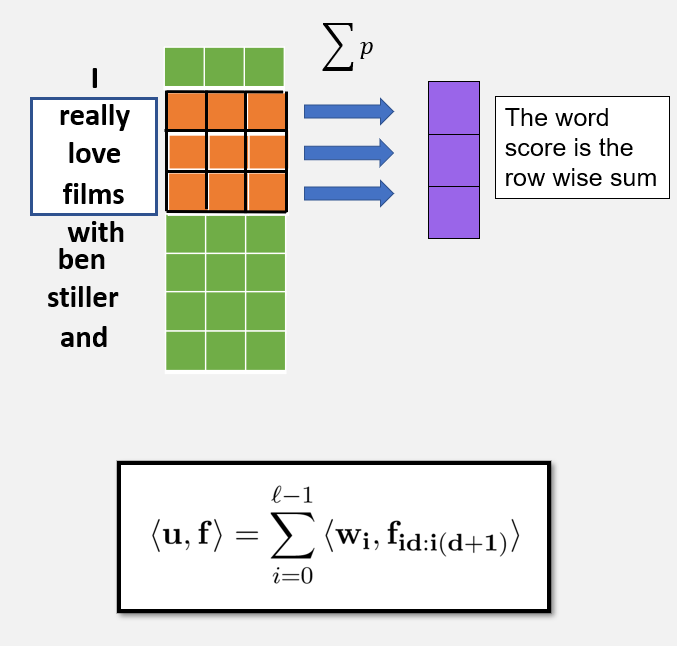

In [109]:
from IPython.display import Image
Image(filename='pics/snippet.png')

Furthermore, we used a relu activation so we know scores are greater than zero. So we know that when each of the filters choose an ngram and score it, it will be greater than zero. Notice that the linear layer weights each filter, were negative weights contribute to label 0 and positive contributes to label 1. Hence we can look at the weights and determine what label each filter is focusing on. 

In [110]:
dense_weights = list(model.parameters())[-2].detach().cpu().numpy()

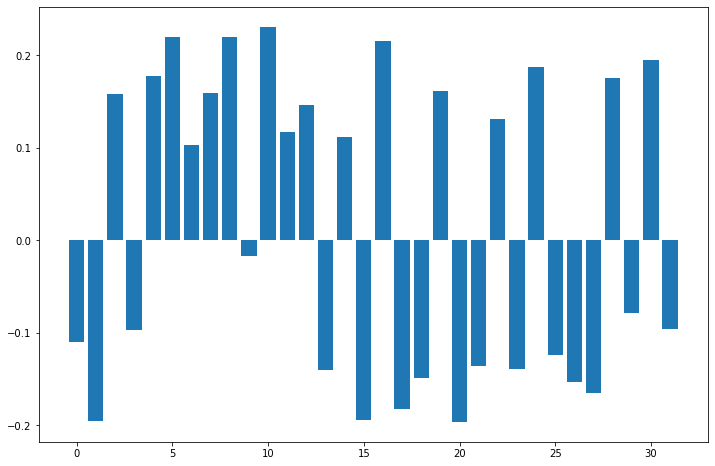

In [111]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12,8))
plt.bar(range(32), dense_weights[0])
plt.show()

# Now just get all the ngrams and calculate their filter scores. We colour code below and add arbitrary thresholds 

In [112]:
from nltk import ngrams

def padder(lst, token, max_len):
    return lst + [token] * (max_len - len(lst))


trigrams = [[x for i, x in enumerate(ngrams(padder(example.text, '<pad>', 200), 3)) if i%3 == 0] for example in train.examples]

In [113]:
temp = next(iter(train_iter)).text

In [114]:
feature_values = model.get_features(temp.T.long().cuda()).detach().cpu().numpy()

In [115]:
feature_values.shape

(64, 32, 66)

In [116]:
from sty import Style, RgbBg, bg

bg.low = Style(RgbBg(0, 0, 250))
bg.mid = Style(RgbBg(0, 100, 0))
bg.high = Style(RgbBg(250, 0, 0))

def color_threshold(x, thresholds=[0, 0.35, 0.7]):
    if thresholds[0] <= x < thresholds[1]:
        return bg.low
    if thresholds[1] <= x < thresholds[2]:
        return bg.mid
    if thresholds[2] < x:
        return bg.high
    else:
        return ''

In [117]:
from termcolor import colored

thresholds = [0.3, 0.6, 0.9]
string = ""
print(bg.low + "Low score", thresholds[0])
print(bg.mid + "Middle score", thresholds[1])
print(bg.high + "High score", thresholds[2])
print("")


Low score 0.3
Middle score 0.6
High score 0.9



# Below we see that the filter has a negative weight and thus contributes to the objective label. The part in red had the highest scores for contributing to this label

In [142]:
INDEX = 20
FILTER = 1

string = ''
for gram, score in zip(trigrams[INDEX], feature_values[INDEX,FILTER]):
    words = ' '.join(gram)
    if words != '<pad> <pad> <pad>':
        string += color_threshold(score, thresholds) + words + ' '
            
print("Filter Weight {0}".format(dense_weights[0,FILTER]))
print("")
print(string)

Filter Weight -0.19541557133197784

elegant and eloquent [meditation] on death and that most elusive of passions , love . 


# Below we see that the filter has a positive weight and thus contributes to the subjective label. The part in red had the highest scores for contributing to this label

In [143]:
INDEX = 20
FILTER = 10

string = ''
for gram, score in zip(trigrams[INDEX], feature_values[INDEX,FILTER]):
    words = ' '.join(gram)
    if words != '<pad> <pad> <pad>':
        string += color_threshold(score, thresholds) + words + ' '
            
print("Filter Weight {0}".format(dense_weights[0,FILTER]))
print("")
print(string)

Filter Weight 0.23094500601291656

elegant and eloquent [meditation] on death and that most elusive of passions , love . 


In [120]:
print("Time: {0}".format(timeit.default_timer() - start_time))

Time: 738.8133151999999
